In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img

from keras import backend as K

from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Reshape
from keras.utils.vis_utils import plot_model

import threading
import pickle
from IPython.display import Image, display

In [ ]:
train_path = "dashcam/frames/training/positive"
test_path = "dashcam/frames/testing/positive"

frames_path = {}

train_data = []
test_data = []

In [ ]:
def make_sequences(frames, mode):
    
    frames = sorted(frames)
    sequences = []

    for i in range(0, 100, 10):
        sequence = frames[i:(i + 10)]
        if(mode == "train"):
            train_data.append(sequence)
        elif(mode == "test"):
            test_data.append(sequence)

In [ ]:
for category in ["train", "test"]:
    data_path = train_path if category == "train" else test_path
    
    for video in os.listdir(data_path):
        frames = []
        for frame in os.listdir(data_path + "/" + video):
            frames.append(video + "_" + frame)
            frames_path[video + "_" + frame] = data_path + "/" + video
        if(len(frames) == 100):
            make_sequences(frames, category)

In [ ]:
def image_to_tensor(filename):
  
    tokens = filename.split("_")
    im = load_img(frames_path[filename] + "/frame_" + tokens[2], target_size = (128, 128))
    im = img_to_array(im)
    im =  im / 255.
    #plt.imshow(im.astype(np.uint8))

    return im

In [ ]:
def sequence_prep(sequence):
  
    x = sequence

    images = []

    for filename in x:
        im = image_to_tensor(filename)
        images.append(im)

    images = np.array(images)  # (20, 256, 256, 3)

    return images

In [ ]:
def batch_prep(batch):
  
    batch_x = []
    batch_y = []

    for sequence in batch:
        images = sequence_prep(sequence)
        batch_x.append(images)
        batch_y.append(images)

    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    #print("(batch_size, no_of_frames, img_height, img_width, channels) = " + str(batch_x.shape))
    #print("(batch_size, no_of_frames, img_height, img_width, channels) = " + str(batch_y.shape))

    return batch_x, batch_y


In [ ]:
class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

In [ ]:
@threadsafe_generator
def data_generator(mode):
    
    data = train_data if mode == "train" else test_data
    np.random.shuffle(data)
  
    batch_size = 5
    nb_batch = len(data) // batch_size
    
    print("Mode: " + mode + " => data generator in work to produce: " + str(nb_batch) + " batches from " + str(len(data)) + " data instances. ")

    while True:
        for i in range(nb_batch):

            beg = i * batch_size
            end = (i * batch_size + batch_size) if i * batch_size < len(data) else -1

            batch = data[beg : end]
            batch_x, batch_y = batch_prep(batch)

            yield batch_x, batch_y

In [ ]:
def conv2d(x, n_filters = 64 , kernel_size = 3, batchnorm = True  , name = None):

    x = TimeDistributed(Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'glorot_uniform', padding = 'same', activation=None , name=name))(x)
    if batchnorm:
        x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Activation('relu'))(x)
    return x

def conv2d_block(x , n_filters=64 , kernel_size = 3, batchnorm = True , name = None):
    x = conv2d(x , n_filters , kernel_size , batchnorm  , name= name+"_conv1")
    x = conv2d(x , n_filters , kernel_size , batchnorm  , name= name+"_conv2")
    return x

In [ ]:
shape = (128,128,3)
n_filters = 32
batchnorm = True
time_step = 10

inp = Input(shape = (time_step,)+shape)


c1 = conv2d_block(inp, n_filters * 1, kernel_size = 3, batchnorm = batchnorm , name = 'c1')
p1 = TimeDistributed(MaxPooling2D((2, 2)))(c1)


c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm , name="c2")
p2 = TimeDistributed(MaxPooling2D((2, 2)))(c2)

c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm , name = "c3")
p3 = TimeDistributed(MaxPooling2D((2, 2)))(c3)

c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm , name = "c4")
p4 = TimeDistributed(MaxPooling2D((2, 2)))(c4)

c5 = conv2d_block(p4, n_filters * 16, kernel_size = 3, batchnorm = batchnorm , name = "c5")

seq = ConvLSTM2D(filters = n_filters * 16 , kernel_size = 1, strides = 1, padding='same' , return_sequences=True ,  name='seq_bottleneck' )(c5)  ## Remember since we are intending to recreate the frames we are intending it to be an identity function i.e use (1,1) filters


u6 = TimeDistributed(Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same' , name = "up1"))(seq)
u6 = Concatenate(axis = -1)([u6, c4])
c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm , name = "c6")

u7 = TimeDistributed(Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same' , name = "up2"))(c6)
u7 = Concatenate(axis = -1)([u7, c3])
c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm , name = "c7")

u8 = TimeDistributed(Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same' , name = "up3"))(c7)
u8 = Concatenate(axis = -1)([u8, c2])
c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm , name = "c8")

u9 = TimeDistributed(Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same' , name = "up4"))(c8)
u9 = Concatenate(axis = -1)([u9, c1])
c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm , name = "c9")

out = TimeDistributed(Conv2D(filters = 3, kernel_size = 1 ,kernel_initializer = 'glorot_uniform', padding = 'same' , activation='relu'))(c9)

u_model = Model(inputs = inp , outputs = out)

#plot_model(u_model, to_file='conv_seq_enc_dec.png', show_shapes=True)
#display(Image('conv_seq_enc_dec.png'))
u_model.summary()

optimizer = Adam(lr=1e-3)
metrics = ['accuracy']
u_model.compile(loss = "mean_squared_error", optimizer = optimizer, metrics = metrics)

In [ ]:
checkpointer = ModelCheckpoint(
        filepath=os.path.join('saved_models', 'identity_frame_reconstruct', 'identity_frame_reconstruct' + \
            '.{epoch:03d}-{loss:.3f}.hdf5'),
        verbose=1,
        save_weights_only=True,
        save_best_only=True)

train_datagen = data_generator("train")
test_datagen = data_generator("test")

history = u_model.fit_generator(generator = train_datagen, steps_per_epoch = 900, epochs = 10, verbose = 1, workers = 4, shuffle = False, validation_data = test_datagen, validation_steps = 300, callbacks = [checkpointer], initial_epoch = 0)

In [ ]:
pickle_out = open("saved_models/identity_frame_reconstruct/history_identity_frame_reconstruct_e20.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [ ]:
model_inference("dashcam/frames/testing/positive/000508")

In [7]:
pickle_in = open("saved_models/identity_frame_reconstruct/history_identity_frame_reconstruct_e20.pickle","rb")
loaded_history = pickle.load(pickle_in)

val_loss = loaded_history["val_loss"]
val_acc = loaded_history["val_acc"]

training_loss = loaded_history["loss"]
training_acc = loaded_history["acc"]

epochs = range(20)

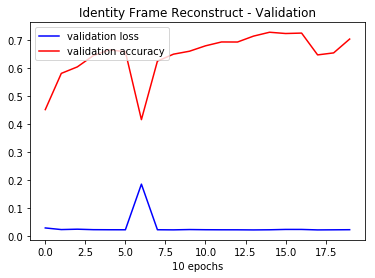

In [8]:
plt.plot(epochs, val_loss, '-b', label='validation loss')
plt.plot(epochs, val_acc, '-r', label='validation accuracy')

plt.xlabel("10 epochs")
plt.legend(loc='upper left')
plt.title("Identity Frame Reconstruct - Validation")

plt.savefig("figures/identity_frame_reconstruct_val" + ".png")  
plt.show()

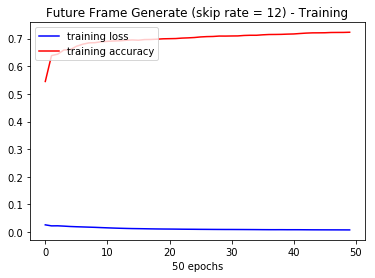

In [15]:
plt.plot(epochs, training_loss, '-b', label='training loss')
plt.plot(epochs, training_acc, '-r', label='training accuracy')

plt.xlabel("10 epochs")
plt.legend(loc='upper left')
plt.title("Identity Frame Reconstruct - Training")

plt.savefig("figures/identity_frame_reconstruct_train" + ".png")  
plt.show()

In [ ]:
def model_inference(video_path): 
    
    file_idx = video_path.split("/")[-1]
    
    frame_names = []
    for frame in os.listdir(video_path):
        frame_names.append(frame)
    frame_names = sorted(frame_names)

    frames = []
    for frame in frame_names:
        img = load_img(video_path + "/" + frame, target_size = (256, 256))
        img = img_to_array(img)
        img =  img / 255.
        frames.append(img)
    frames = np.array(frames)

    u_model.load_weights("saved_models/future_frame_generate_skip12/future_frame_regenerate.007-0.019.hdf5")

In [ ]:
model_inference("dashcam/frames/testing/positive/000508")